In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm.notebook import tqdm



%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kdsh-dataset/btc_3m.csv
/kaggle/input/kdsh-dataset/btc_1h.csv
/kaggle/input/kdsh-dataset/btc_15m.csv
/kaggle/input/kdsh-dataset/btc_30m.csv
/kaggle/input/kdsh-dataset/btc_4h.csv
/kaggle/input/kdsh-dataset/btc_6h.csv
/kaggle/input/kdsh-dataset/btc_2h.csv
/kaggle/input/kdsh-dataset/btc_5m.csv


In [61]:
btc_6h = pd.read_csv("/kaggle/input/kdsh-dataset/btc_6h.csv", index_col = ['datetime'], parse_dates = ['datetime'])

In [62]:
btc_6h

,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13155.38,13558.99,2421.241182
2018-01-01 11:30:00,13539.00,13818.55,13001.13,13220.56,1876.934392
2018-01-01 17:30:00,13220.56,13330.00,12750.00,13022.00,2427.898747
2018-01-01 23:30:00,13007.87,13599.70,12940.00,13380.00,1883.841523
2018-01-02 05:30:00,13382.16,13850.00,12890.02,13166.95,3957.954564
...,...,...,...,...,...
2022-01-30 05:30:00,38166.83,38300.00,37737.49,38139.39,4656.397760
2022-01-30 11:30:00,38139.38,38359.26,37795.00,38110.02,6113.435610
2022-01-30 17:30:00,38110.03,38153.82,37712.05,37991.00,4075.221880


### Plotting OHLC:

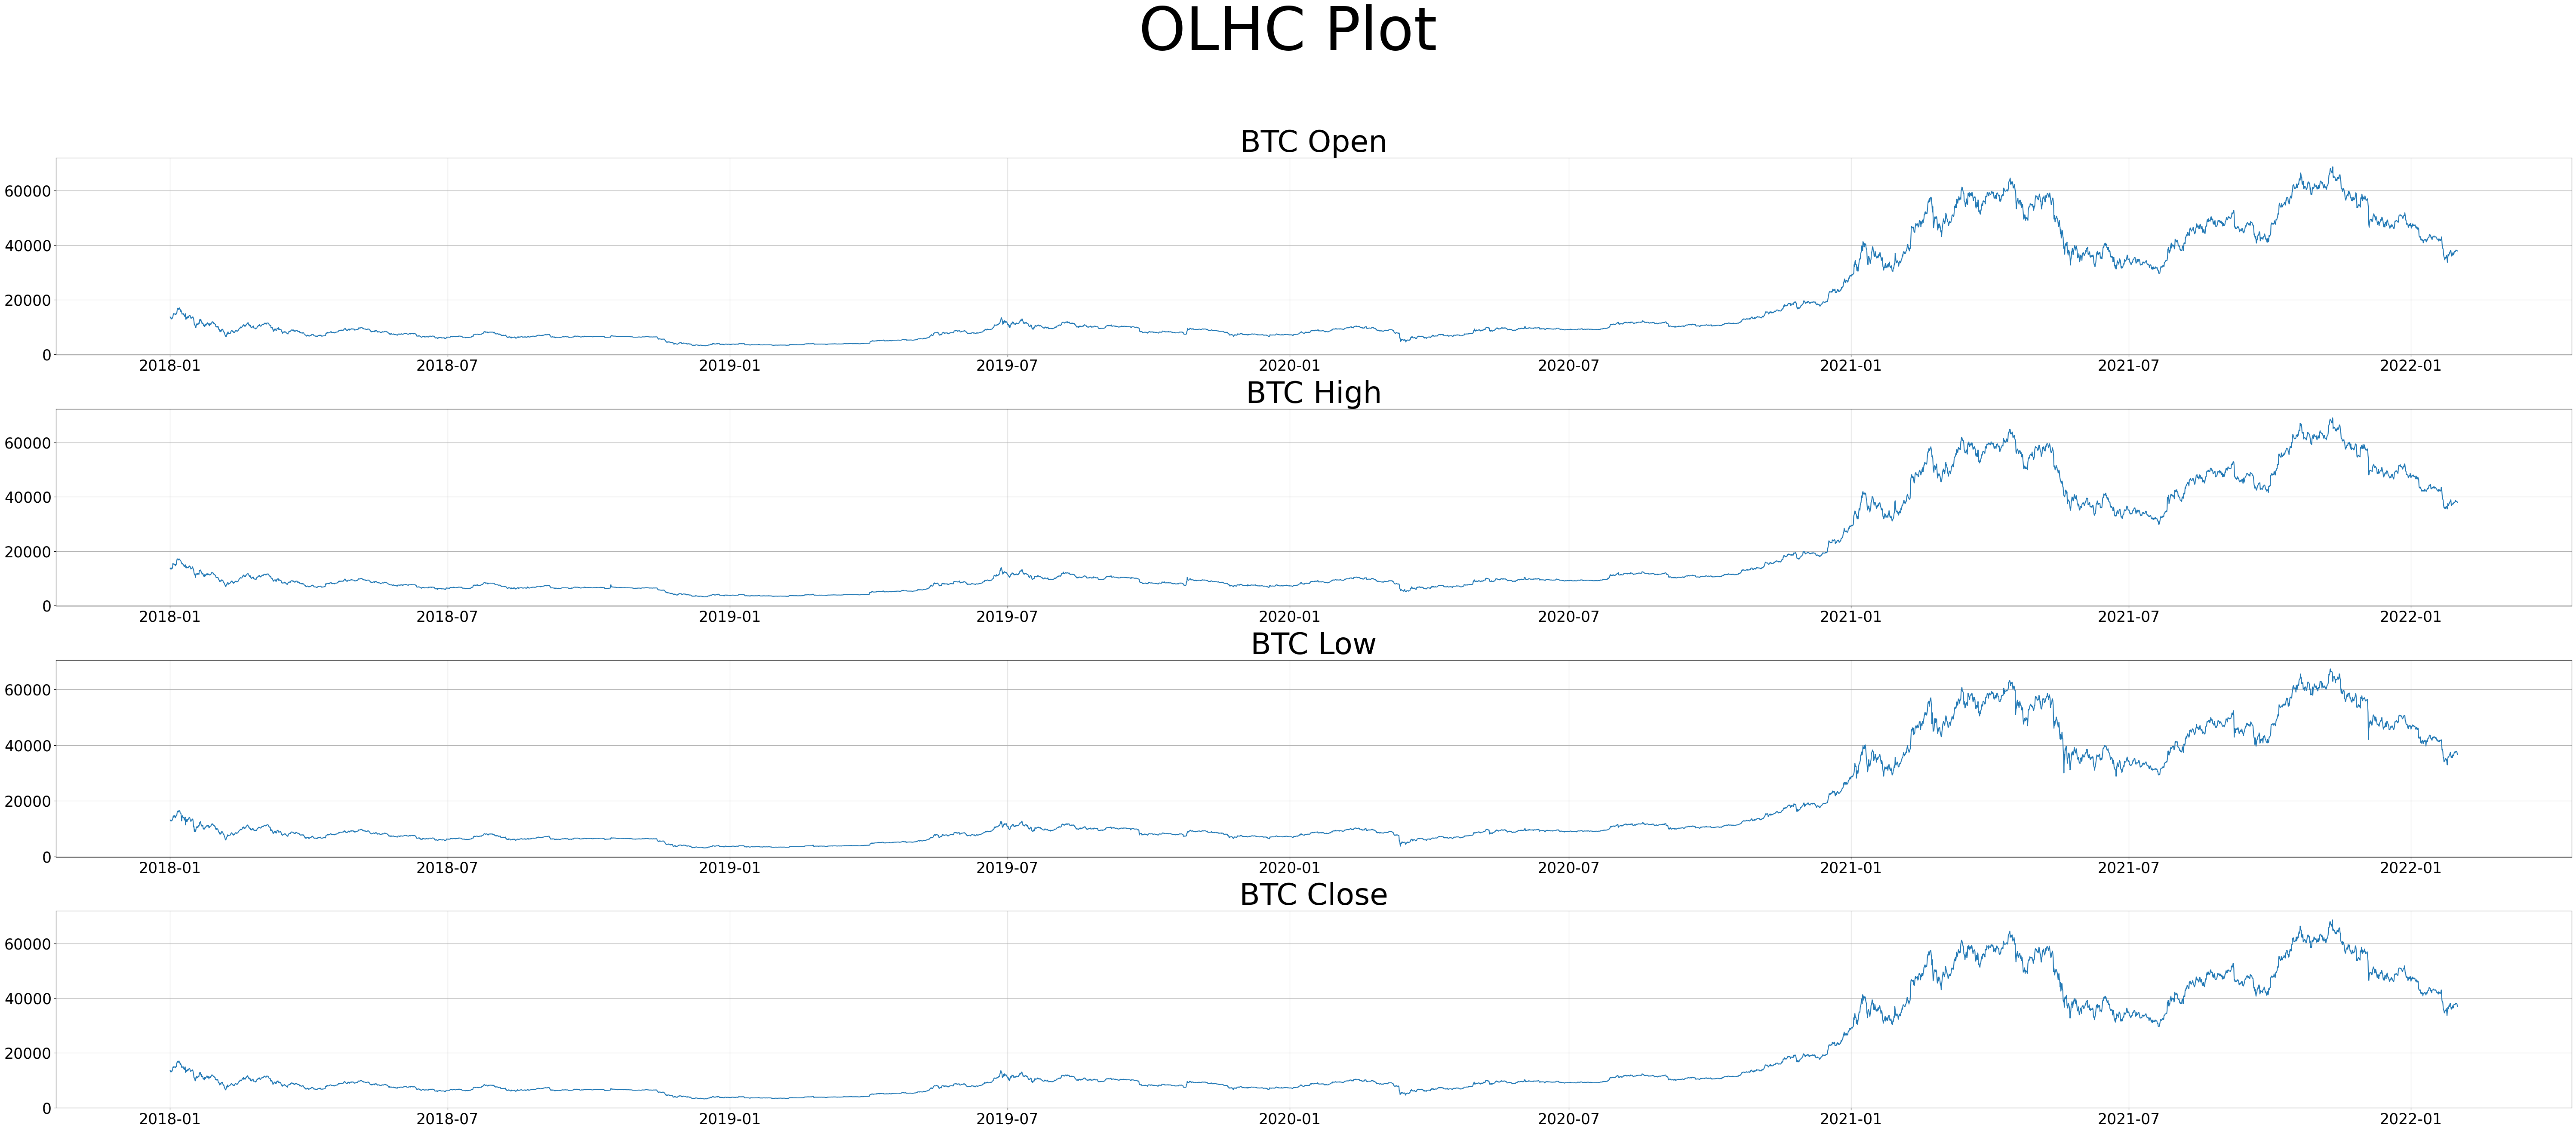

In [63]:
fig, axes = plt.subplots(4,1, figsize=(60,25))

axes[0].plot(btc_6h.open)
axes[1].plot(btc_6h.high)
axes[2].plot(btc_6h.low)
axes[3].plot(btc_6h.close)

axes[0].set_title('BTC Open', fontsize=50)
axes[1].set_title('BTC High', fontsize=50)
axes[2].set_title('BTC Low', fontsize=50)
axes[3].set_title('BTC Close', fontsize=50)

axes[0].tick_params(axis='x', labelsize=25)
axes[1].tick_params(axis='x', labelsize=25)
axes[2].tick_params(axis='x', labelsize=25)
axes[3].tick_params(axis='x', labelsize=25)

axes[0].tick_params(axis='y', labelsize=25)
axes[1].tick_params(axis='y', labelsize=25)
axes[2].tick_params(axis='y', labelsize=25)
axes[3].tick_params(axis='y', labelsize=25)

for i in range(4):
    axes[i].grid(True)

fig.suptitle('OLHC Plot', y=1.05, fontsize = 100)
plt.subplots_adjust(hspace=5)

plt.tight_layout()
plt.show()

# Section 1: Analysis of components

## Defining metric MAPE:

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Analysing Close

In [ ]:
close_df = pd.DataFrame(btc_6h.close)
close_df

### Approach: Getting rid of non-stationarity and building SARIMA

#### Using Dickey-Fuller to test for stationarity

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

#### Applying a lag of 60, our data has intervals of 6 hrs so the lag is of (6x60/24) = 15 days

In [ ]:
tsplot(close_df.close, lags = 60)

### Applying differencing to make the data stationary

In [ ]:
close_df['diff1'] = close_df.close - close_df.close.shift(1)

In [ ]:
tsplot(close_df.diff1[1:], lags = 60)

### We see that our series has non stationarity due to increasing variance. We apply Box Cox Transformation to stabilize it

##### We will later need to invert the Box Cox function so creationg an inverse_boxcox function

In [ ]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [ ]:
close_df['close_BxCx'], lambda_ = scs.boxcox(close_df['close'])
close_df['diff1_BxCx'] = close_df.close_BxCx - close_df.close_BxCx.shift(1)
tsplot(close_df.diff1_BxCx[1:], lags = 60)

Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is stationary, and the variance has also stabilized.

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

start_date = close_df.index[0]
date_index = pd.date_range(start=start_date, periods=close_df.shape[0], freq='6H')
close_df.index = date_index
decomposition = sm.tsa.seasonal_decompose(close_df.diff1_BxCx[1:], model='additive')
fig = decomposition.plot()
plt.show()

There is a visible seasonal component, with seasonality(**s**) of about 6 days = (6x24/6) = 24(30 spikes in 6months period)

Applying seasonal differencing,

In [ ]:
close_df["diff1_BxCxS"] = close_df.diff1_BxCx - close_df.diff1_BxCx.shift(24)
tsplot(close_df.diff1_BxCxS[25:], lags = 60)

Perfect! Our series now looks like something undescribable, oscillating around zero. The Dickey-Fuller test indicates that it is stationary, and the variance has stabilized. We can finally start modeling!

## Building SARIMA

- $p$ is most probably 4 since it is the last significant lag on the PACF, after which, most others are not significant. 
- $d$ equals 1 because we had first differences
- $q$ should be somewhere around 4 as well as seen on the ACF
- $P$ might be 2, since 24-th and 48-th lags are somewhat significant on the PACF
- $D$ again equals 1 because we performed seasonal differentiation
- $Q$ is probably 1. The 24-th lag on ACF is significant while the 48-th is not.

In [ ]:
p_ = range(2,5)
d = 1
q_ = range(2,5)
P_ = range(0,3)
D = 1
Q_ = range(0,2)
s = 24

# creating list with all the possible combinations of parameters
parameters = product(p_,q_,P_,Q_)
parameters_list = list(parameters)

## Hyperparameter Tuning

### Writing a function that performs a Grid Search over all the hyperparameters we chose

In [ ]:
def optimizeSARIMA(series, parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(series, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)
                                           ).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(close_df.close_BxCx, parameters_list, d, D, s)

In [ ]:
result_table

In [ ]:
# set the parameters that give the lowest AIC
try:
    p, q, P, Q = result_table.parameters[0]
except:
    p,q,P,Q,d,D = 2,4,0,1,1,1
    
prediction_size = 100
train_df = close_df[:-prediction_size]
best_model = sm.tsa.statespace.SARIMAX(
    train_df.close_BxCx, order=(p, d, q)
    , seasonal_order=(P, D, Q, s)
).fit(disp=-1)
print(best_model.summary())

In [ ]:
tsplot(best_model.resid[24 + 1 :], lags=60)

In [ ]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data = inverse_boxcox(data, lambda_)
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:d] = np.NaN
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = pd.concat([data.arima_model, forecast])
    forecast = inverse_boxcox(forecast, lambda_)

    plt.figure(figsize=(15, 7))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(close_df.close, label="actual")
    plt.legend()
    plt.grid(True);
    return forecast

In [ ]:
Close = pd.DataFrame(train_df.close_BxCx)

In [ ]:
Close

In [ ]:
forecast = plotSARIMA(Close, best_model, prediction_size)

In [ ]:
FORECAST = pd.DataFrame(forecast)
forecast_range = forecast[-prediction_size:][:-1]

In [ ]:
actual_range = close_df[-prediction_size+1: ].close

In [ ]:
mean_absolute_percentage_error(actual_range, forecast_range)

### Using Time Aware Cross Validation to see robustness

In [ ]:
close_series = pd.Series(btc_6h.close)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit


def timeseriesCVscore(params, series, s=24, d = 1, D = 1, splits = 20):
    """
        Returns error on CV  
        series - dataset with timeseries
    """
    # errors array
    errors = []
#     values = series.reset_index()
    values = series.values
    p, q, P, Q = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=splits)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        col, lambda_ = scs.boxcox(values[train].ravel())
        model = sm.tsa.statespace.SARIMAX(col, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
        forecast = model.predict(start = len(train), end = len(train)+len(test)-1)
        forecast = inverse_boxcox(forecast, lambda_)
        actual = values[test]
        error = mean_absolute_percentage_error(actual, forecast)
        errors.append(error)

    return errors

In [ ]:
%%time
error_list = timeseriesCVscore((p,q,P,Q), close_series)

In [ ]:
error_list

In [ ]:
np.array(error_list).mean()

##### In the context of financial markets, predicting precise price movements is challenging due to the inherent volatility and randomness. Cryptocurrencies, including Bitcoin, are known for their price volatility. A 22% MAPE might be acceptable in this context.

### Now from the graphs of the OLHC components, we see that they are almost same, so we can use the same parameters viz. p, q, d, P, D and Q

# Section 2: Building final model

In [ ]:
%reset -f  #clearing all variables from the namespace to have a fresh start

In [5]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

In [103]:
class BTC_SARIMA:
    '''
    df - DataFrame consisting of an index column of type 'datetime' and an column (any of OHLC)
    params - parameters for the SARIMA model, viz. p, d, q, P, D, Q, s
    interval - time interval of the datetime index
    n_steps - number of future time steps to be predicted
    '''
    def __init__(self, df, n_steps, look_back = 150, params = (2, 1, 4, 0, 1, 1, 24), interval = '6H'):
        self.lkbk = look_back
        self.date_range = pd.date_range(start=df.index[0], periods=df.shape[0], freq=interval)
        df.index = self.date_range
        start_date = df.index[0]
        end_date = df.index[-1]
        train_start = end_date - pd.to_timedelta(interval)*self.lkbk
        self.df = df
        self.train_df = self.df.loc[train_start:end_date,:]
        self.train_date_range = self.train_df.index
        self.train_values = self.train_df.values
        self.cols = df.columns
        self.n_steps = n_steps
        self.params = params
        self.freq = interval
        self.model = None
        self.forecast = None
        self.fitnforecast = None
        self.forecast_df = None
        self.orig_df = None
        self.sharpe_ratio = None
        self.annualized_returns = None
        self.max_drawdown = None
        
    def stabilize_col(self, col = None):
        col = col or self.train_values
        col, lambda_ = scs.boxcox(col.ravel())
        col_BxCx = pd.Series(col)
        col_BxCx.index = self.train_date_range
        return (col_BxCx, lambda_)
    
    def inverse_boxcox(self, y = None, lambda_ = None):
        if y is None:
            y = self.col_BxCx_train
        lambda_ = lambda_ or self.lambda_
        return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)
        
    def SARIMA_fit(self):
        self.col_BxCx_train, self.lambda_ = self.stabilize_col()
        p, d, q, P, D, Q, s = self.params
        best_model = sm.tsa.statespace.SARIMAX(self.col_BxCx_train, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)
        self.model = best_model
        return best_model
    
    def forecastSARIMA(self, model = None):
        model = model or self.model
        lambda_ = self.lambda_ 
        forecast = model.predict(start = self.train_df.shape[0], end = self.train_df.shape[0]+self.n_steps)
        self.forecast = forecast
        self.fitnforecast = pd.concat([model.fittedvalues, self.forecast])
        self.fitnforecast = self.inverse_boxcox(self.fitnforecast, lambda_)[1:] 
        self.forecast = self.inverse_boxcox(self.forecast, lambda_)
        return self.fitnforecast
    
    def forecastDF(self, forecast = None):
        forecast = forecast or self.forecast
        forecast_df = pd.DataFrame(forecast)
        forecast_df.columns = self.cols
        forecast_df = pd.concat([self.df, forecast_df])
        self.forecast_df = forecast_df
        return forecast_df
    
    def plot_df(self, actual_df = None):
        plt.figure(figsize=(15, 7))
        plt.plot(self.forecast_df[self.cols[-1]], color='r', label="model")
        plt.title(self.cols[-1])
        plt.axvspan(self.df.index[-1], self.forecast_df.index[-1], alpha=0.5, color='lightgrey')
        try:
            plt.plot(actual_df, label="actual")
        except:
            print("To plot actual graph along with prediction, please pass the actual df as argument")
        plt.plot()
        plt.legend()
        plt.grid(True);
        plt.show()
        
    def gen_signals(self, stop_loss_percentage = 0.02, risk_reward_ratio = 2):
        # Replace placeholders and customize according to your strategy
        self.forecast_df['Close_MA_13'] = self.forecast_df['close'].rolling(window=13).mean()
        self.forecast_df['Close_MA_24'] = self.forecast_df['close'].rolling(window=24).mean()
#         predicted_df = predicted_df.iloc[50:]
        self.forecast_df['stop_loss'] = self.forecast_df['close'] * (1 - stop_loss_percentage)
        self.forecast_df['take_profit'] = self.forecast_df['close'] * (1 + risk_reward_ratio * stop_loss_percentage)

        # Generate signals based on moving average crossovers
        self.forecast_df['signal'] = 0  # Default: Hold
        self.forecast_df['signal'][self.forecast_df['Close_MA_13'] > self.forecast_df['Close_MA_24']] = 1  # Buy signal
        self.forecast_df['signal'][self.forecast_df['Close_MA_13'] < self.forecast_df['Close_MA_24']] = -1  # Sell signal
        self.forecast_df['signal'][self.forecast_df['close'] < self.forecast_df['stop_loss']] = -1  # Sell signal (stop loss)
        self.forecast_df['signal'][self.forecast_df['close'] > self.forecast_df['take_profit']] = -1  # Sell signal (take profit)
        self.forecast_df['signal'][(self.forecast_df['Close_MA_13'] > self.forecast_df['Close_MA_24']) & (self.forecast_df['close'] < self.forecast_df['stop_loss'])] = 1  # Buy signal
        
        flag = 0
        sum_signals = 0
        modified_signals = []

        for _, row in self.forecast_df.iterrows():
            if flag == -1 and row['signal'] == 1:
                flag = 0
                sum_signals += row['signal']
                modified_signals.append(row['signal'])
                continue
                
            if flag == 1 and row['signal'] == -1:
                flag = 0
                sum_signals += row['signal']
                modified_signals.append(row['signal'])
                continue
            
            if flag == 0 and row['signal'] == 1:
                flag = 1
                sum_signals += row['signal']
                modified_signals.append(row['signal'])
                continue
                
            if flag == 0 and row['signal'] == -1:
                flag = -1
                sum_signals += row['signal']
                modified_signals.append(row['signal'])
                continue
                
            if flag:
                modified_signals.append(0)
            else:
                modified_signals.append(row['signal'])

        if sum_signals:
            modified_signals[-1] = sum_signals * -1

        # Update the DataFrame with the modified signals
        self.forecast_df['signal'] = modified_signals
        return self.forecast_df
        
    def backtesting(self, orig_df = None):
        try:
            self.orig_df = orig_df.copy()
            # Calculate daily returns based on trade signals
            self.orig_df['daily_returns'] = orig_df['close'].pct_change() * self.forecast_df['signal'].shift(1)

            # Calculate cumulative returns and equity curve
            self.orig_df['cumulative_returns'] = (1 + self.orig_df['daily_returns']).cumprod()
            self.orig_df['equity_curve'] = 100000 * self.orig_df['cumulative_returns']

            # Performance Metrics
            self.sharpe_ratio = self.orig_df['daily_returns'].mean() / self.orig_df['daily_returns'].std() * np.sqrt(252)
            self.annualized_returns = (self.orig_df['cumulative_returns'].iloc[-1]) ** (252 / len(self.orig_df)) - 1
            self.max_drawdown = (1 - self.orig_df['cumulative_returns'] / self.orig_df['cumulative_returns'].cummax()).max()
        except:
            print("Performance metrics to be calculated on basis of actual trend")
            print(f"Please provide the actual DataFrame from {self.forecast_df.index[0]} to {self.forecast_df.index[-1]} having intervals {self.freq}")
            
    def backtesting_visualizer(self):
        if self.orig_df is None and self.orig_df.empty:
            print("Run backtesting method with actual DataFrame prior to this")
            return 0
        # Visualizations
        plt.figure(figsize=(8, 4))
        plt.plot(self.orig_df.index, self.orig_df['equity_curve'], label='Equity Curve')
        plt.title('Equity Curve Over Time')
        plt.xlabel('Date')
        plt.ylabel('Equity (USDT)')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

        # Trade History
        buy_signals = self.forecast_df[self.forecast_df['signal'] == 1]
        sell_signals = self.forecast_df[self.forecast_df['signal'] == -1]

        # Plot buy and sell signals on the price chart
        plt.figure(figsize=(8, 4))
        plt.plot(self.orig_df.index, self.orig_df['close'], label='BTC Prices')
        plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', label='Buy Signal')
        plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', label='Sell Signal')
        plt.xticks(rotation=45)
        plt.title('Buy and Sell Signals on BTC Prices')
        plt.xlabel('Date')
        plt.ylabel('BTC Price (USDT)')
        plt.legend()
        plt.show()
        
    def risk_visualizer(self):
        if self.orig_df is None and self.orig_df.empty:
            print("Run backtesting method with actual DataFrame prior to this")
            return 0
        plt.figure(figsize=(8, 4))
        plt.plot(self.orig_df.index, self.orig_df['close'], label='BTC Prices')
        plt.plot(self.forecast_df.index, self.forecast_df['stop_loss'], label='Stop Loss Level', linestyle='--', color='r')
        plt.plot(self.forecast_df.index, self.forecast_df['take_profit'], label='Take Profit Level', linestyle='--', color='g')
        plt.xticks(rotation=45)
        plt.title('Stop Loss and Take Profit Levels Over Time')
        plt.xlabel('Date')
        plt.ylabel('BTC Price (USDT)')
        plt.legend()
        plt.show()
        
        # Print Performance Metrics
        print(f"Sharpe Ratio: {self.sharpe_ratio:.4f}")
        print(f"Annualized Returns: {self.annualized_returns:.4f}")
        print(f"Maximum Drawdown: {self.max_drawdown:.4f}")
    
    


In [104]:
close_df = pd.DataFrame(btc_6h.close)
close_df

,close
datetime,
2018-01-01 05:30:00,13558.99
2018-01-01 11:30:00,13220.56
2018-01-01 17:30:00,13022.00
2018-01-01 23:30:00,13380.00
2018-01-02 05:30:00,13166.95
...,...
2022-01-30 05:30:00,38139.39
2022-01-30 11:30:00,38110.02
2022-01-30 17:30:00,37991.00


In [105]:
prediction_size = 24
# look_back = 150
actual_end_date = '2022-01-31 05:30:00'
# train_start_date = pd.to_datetime(train_end_date) - pd.Timedelta(hours=6)*look_back
train_end_date = pd.to_datetime(actual_end_date) - pd.Timedelta(hours=6)*prediction_size
train_df = close_df.loc[:train_end_date, :]
actual_df = close_df.loc[:str(actual_end_date), :]

In [106]:
sarima = BTC_SARIMA(train_df, prediction_size+5)

In [107]:
%%time
model = sarima.SARIMA_fit()

CPU times: user 14.1 s, sys: 11.2 s, total: 25.3 s
Wall time: 6.83 s


In [108]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  151
Model:             SARIMAX(2, 1, 4)x(0, 1, [1], 24)   Log Likelihood               -3735.755
Date:                              Sat, 20 Jan 2024   AIC                           7487.510
Time:                                      15:06:53   BIC                           7510.200
Sample:                                  12-17-2021   HQIC                          7496.728
                                       - 01-23-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2413      1.431      0.169      0.866      -2.564       3.046
ar.L2          0.65

In [109]:
forecast = sarima.forecastSARIMA()

In [110]:
forecast_df = sarima.forecastDF()

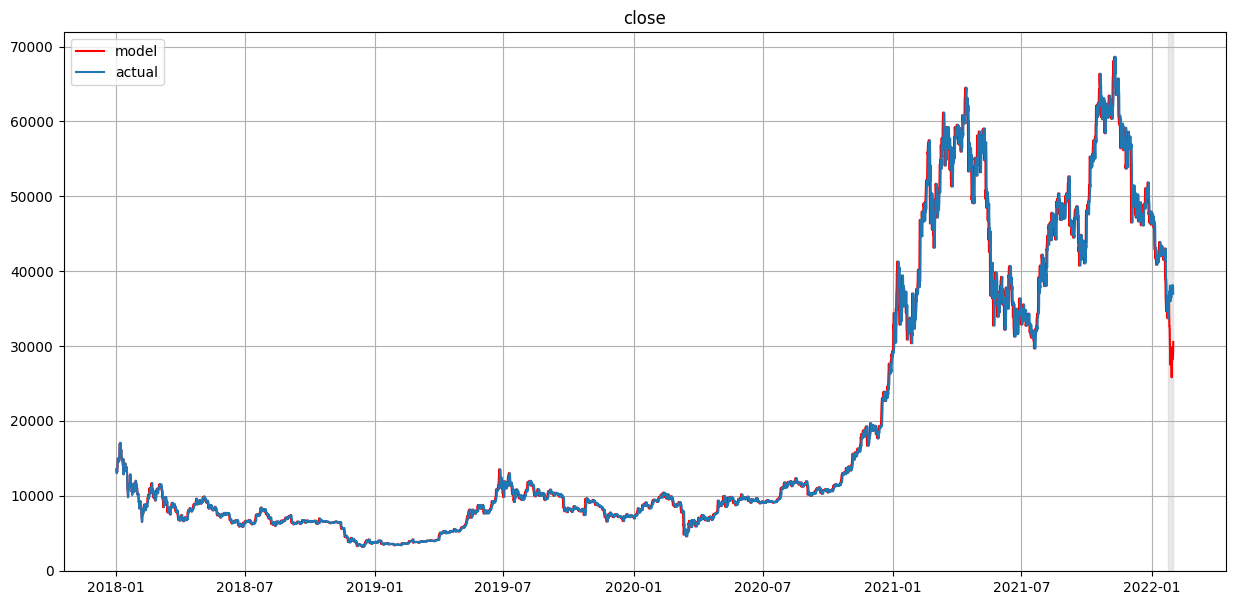

In [111]:
sarima.plot_df(actual_df)

In [112]:
forecast_sigs = sarima.gen_signals()

In [113]:
sarima.backtesting(actual_df)

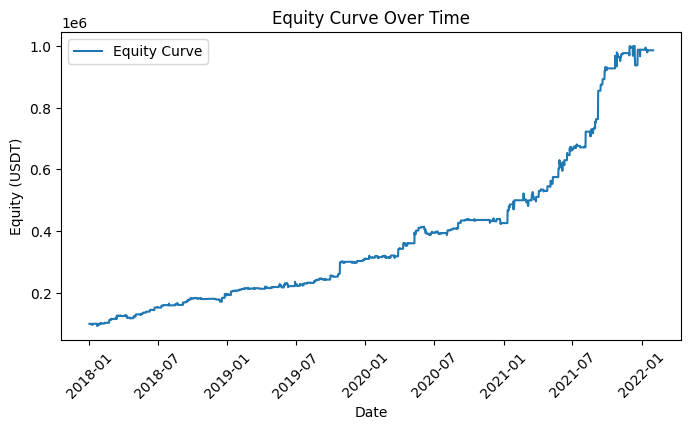

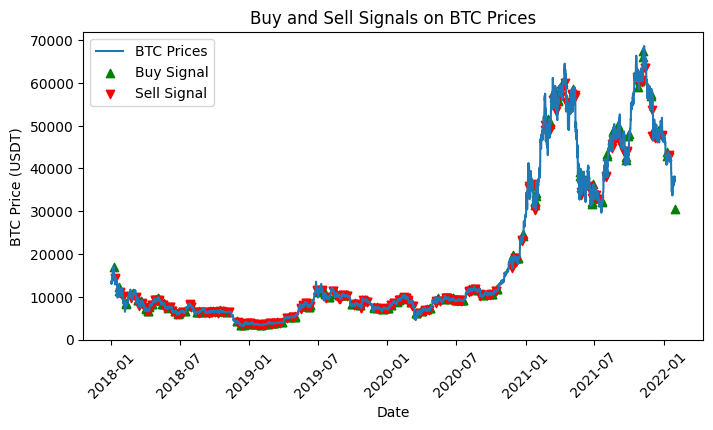

In [114]:
sarima.backtesting_visualizer()

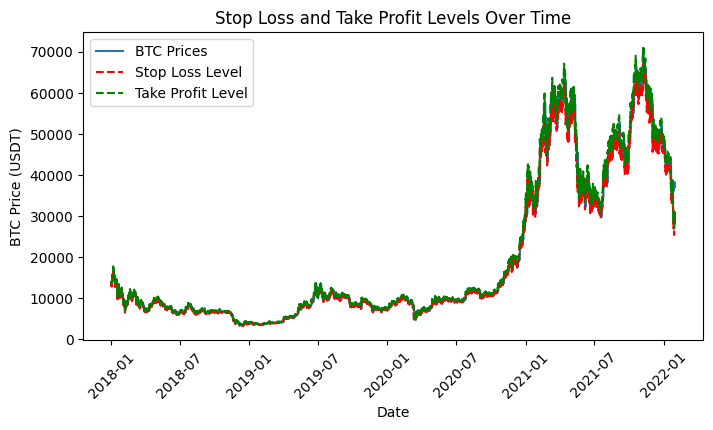

Sharpe Ratio: 1.1299
Annualized Returns: 0.1016
Maximum Drawdown: 0.0798


In [115]:
sarima.risk_visualizer()

In [16]:
forecast_sigs.signal.value_counts()

signal
 0.0    5657
-1.0     154
 1.0     154
Name: count, dtype: int64

In [176]:
signals = forecast_sigs.signal.astype('int')

In [178]:
signals_df = pd.DataFrame(signals)

In [180]:
signals_df.columns = ['signals']

In [181]:
signals_df

,signals
2018-01-01 05:30:00,0
2018-01-01 11:30:00,0
2018-01-01 17:30:00,0
2018-01-01 23:30:00,0
2018-01-02 05:30:00,0
...,...
2022-01-30 05:30:00,0
2022-01-30 11:30:00,0
2022-01-30 17:30:00,0
2022-01-30 23:30:00,0


In [215]:
submission_df = pd.concat([btc_6h, signals_df], axis = 1)

In [216]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 5965 entries, 2018-01-01 05:30:00 to 2022-01-31 05:30:00

Freq: 6H

Data columns (total 6 columns):

 #   Column   Non-Null Count  Dtype  

---  ------   --------------  -----  

 0   open     5959 non-null   float64

 1   high     5959 non-null   float64

 2   low      5959 non-null   float64

 3   close    5959 non-null   float64

 4   volume   5959 non-null   float64

 5   signals  5965 non-null   int64  

dtypes: float64(5), int64(1)

memory usage: 326.2 KB


In [217]:
submission_df.loc[submission_df.isnull().any(axis=1)]

,open,high,low,close,volume,signals
2018-02-08 11:30:00,NaN,NaN,NaN,NaN,NaN,0
2018-02-08 17:30:00,NaN,NaN,NaN,NaN,NaN,0
2018-02-08 23:30:00,NaN,NaN,NaN,NaN,NaN,0
2018-02-09 05:30:00,NaN,NaN,NaN,NaN,NaN,0
2018-06-26 11:30:00,NaN,NaN,NaN,NaN,NaN,0
2019-05-15 11:30:00,NaN,NaN,NaN,NaN,NaN,0


In [218]:
submission_df.signals.value_counts()

signals
 0    5657
-1     154
 1     154
Name: count, dtype: int64

In [221]:
submission_df.reset_index(inplace=True)


In [226]:
submission_df.rename(columns = {'index':'datetime'}, inplace = True)

In [227]:
csv_file_path = 'submission_sarima_.csv'

In [228]:
submission_df.to_csv(csv_file_path, index = False)